In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
import os 
import cv2
from tqdm import tqdm
import glob
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, Flatten
from keras import regularizers

Using plaidml.keras.backend backend.


In [2]:
path_train_nor = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Train/"
# path_train_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Train_Noise/"

path_test_nor =  "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Test/"
# path_test_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Test_Noise/"

data_train_denoise = path_train_nor
# data_train_noise = path_train_noi
data_test_denoise = path_test_nor
# data_test_noise = path_test_noi

siz_h = 256
siz_w = 40
def train_data_with_label_normal():
    train_image = []
    for i in tqdm(glob.glob(os.path.join(data_train_denoise, "*", "*"))):
        path = i
        img = cv2.imread(path, 0)
        img = cv2.resize(img,(siz_h,siz_w))
        train_image.append([np.array(img)])
#     shuffle(train_image)
    return train_image

# def train_data_with_label_noise():
#     train_image = []
#     for i in tqdm(glob.glob(os.path.join(data_train_noise, "*", "*"))):
#         path = i
#         img = cv2.imread(path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img,(siz_h,siz_w))
#         train_image.append([np.array(img)])
# #     shuffle(train_image)
#     return train_image

def test_data_with_label_normal():
    test_image = []
    for i in tqdm(glob.glob(os.path.join(data_test_denoise, "*", "*"))):
        path = i
        img = cv2.imread(path, 0)
        img = cv2.resize(img,(siz_h, siz_w))
        test_image.append([np.array(img)])
#     shuffle(test_image)
    return test_image

# def test_data_with_label_noise():
#     test_image = []
#     for i in tqdm(glob.glob(os.path.join(data_test_noise, "*", "*"))):
#         path = i
#         img = cv2.imread(path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img,(siz_h, siz_w))
#         test_image.append([np.array(img)])
# #     shuffle(test_image)
#     return test_image

In [3]:
training_images_normal = train_data_with_label_normal()
testing_images_normal = test_data_with_label_normal()

train_img_data_normal = np.array([i[0] for i in training_images_normal]).reshape(-1,siz_w, siz_h)
test_img_data_normal = np.array([i[0] for i in testing_images_normal]).reshape(-1, siz_w, siz_h)

100%|██████████| 2280/2280 [00:00<00:00, 4724.93it/s]


In [4]:
max_values = float(train_img_data_normal.max())

x_train_normal = train_img_data_normal.astype('float')/max_values
x_test_normal = test_img_data_normal.astype('float')/max_values

In [5]:
print(x_train_normal.shape)
print(x_test_normal.shape)

(7800, 40, 256)
(2280, 40, 256)


In [6]:
x_train = x_train_normal.reshape((len(x_train_normal), np.prod(x_train_normal.shape[1:])))
x_test = x_test_normal.reshape((len(x_test_normal), np.prod(x_test_normal.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(7800, 10240)
(2280, 10240)


In [7]:
input_dim = x_train.shape[1]
encoding_dim = 500

compression_factor = float(input_dim / encoding_dim)

print("Hệ số nén :", compression_factor)

Hệ số nén : 20.48


In [8]:
autoencoder = Sequential()

autoencoder.add(Dense(10* encoding_dim, input_shape = (input_dim,), activation = "relu"))
autoencoder.add(Dense(5* encoding_dim, activation = "relu"))
autoencoder.add(Dense(encoding_dim, activation = "relu"))

autoencoder.add(Dense(5* encoding_dim, activation ="relu"))
autoencoder.add(Dense(10* encoding_dim, activation ="relu"))

autoencoder.add(Dense(input_dim, activation = "sigmoid"))

autoencoder.summary()

INFO:plaidml:Opening device "opencl_nvidia_quadro_rtx_4000.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              51205000  
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1250500   
_________________________________________________________________
dense_4 (Dense)              (None, 2500)              1252500   
_________________________________________________________________
dense_5 (Dense)              (None, 5000)              12505000  
_________________________________________________________________
dense_6 (Dense)              (None, 10240)             51210240  
Total params: 129,925,740
Trainable params: 129,925,740
Non-trainable params: 0
______________________________________________________________

In [9]:
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              51205000  
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1250500   
Total params: 64,958,000
Trainable params: 64,958,000
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(optimizer='adam', loss= 'binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                validation_data=(x_test, x_test))

Train on 7800 samples, validate on 2280 samples
Epoch 1/100
7800/7800 [==============================] - 9s 1ms/step - loss: 0.5881 - val_loss: 0.5626
Epoch 2/100
7800/7800 [==============================] - 6s 822us/step - loss: 0.5630 - val_loss: 0.5585
Epoch 3/100
7800/7800 [==============================] - 7s 838us/step - loss: 0.5586 - val_loss: 0.5567
Epoch 4/100
7800/7800 [==============================] - 7s 838us/step - loss: 0.5579 - val_loss: 0.5568
Epoch 5/100
7800/7800 [==============================] - 7s 848us/step - loss: 0.5578 - val_loss: 0.5562
Epoch 6/100
7800/7800 [==============================] - 7s 864us/step - loss: 0.5576 - val_loss: 0.5565
Epoch 7/100
7800/7800 [==============================] - 7s 851us/step - loss: 0.5573 - val_loss: 0.5558
Epoch 8/100
7800/7800 [==============================] - 7s 854us/step - loss: 0.5716 - val_loss: 0.5681
Epoch 9/100
7800/7800 [==============================] - 7s 856us/step - loss: 0.5605 - val_loss: 0.5566
Epoch 10/

Epoch 78/100
7800/7800 [==============================] - 7s 860us/step - loss: 0.5538 - val_loss: 0.5530
Epoch 79/100
7800/7800 [==============================] - 7s 864us/step - loss: 0.5537 - val_loss: 0.5531
Epoch 80/100
7800/7800 [==============================] - 7s 864us/step - loss: 0.5537 - val_loss: 0.5529
Epoch 81/100
7800/7800 [==============================] - 7s 867us/step - loss: 0.5536 - val_loss: 0.5528
Epoch 82/100
7800/7800 [==============================] - 7s 866us/step - loss: 0.5535 - val_loss: 0.5528
Epoch 83/100
7800/7800 [==============================] - 7s 880us/step - loss: 0.5536 - val_loss: 0.5530
Epoch 84/100
7800/7800 [==============================] - 7s 862us/step - loss: 0.5536 - val_loss: 0.5528
Epoch 85/100
7800/7800 [==============================] - 7s 867us/step - loss: 0.5533 - val_loss: 0.5528
Epoch 86/100
7800/7800 [==============================] - 7s 875us/step - loss: 0.5533 - val_loss: 0.5528
Epoch 87/100
7800/7800 [======================

In [11]:
num_images = 10
np.random.seed(1000)
random_test_images = np.random.randint(x_test.shape[0], size = num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test) 

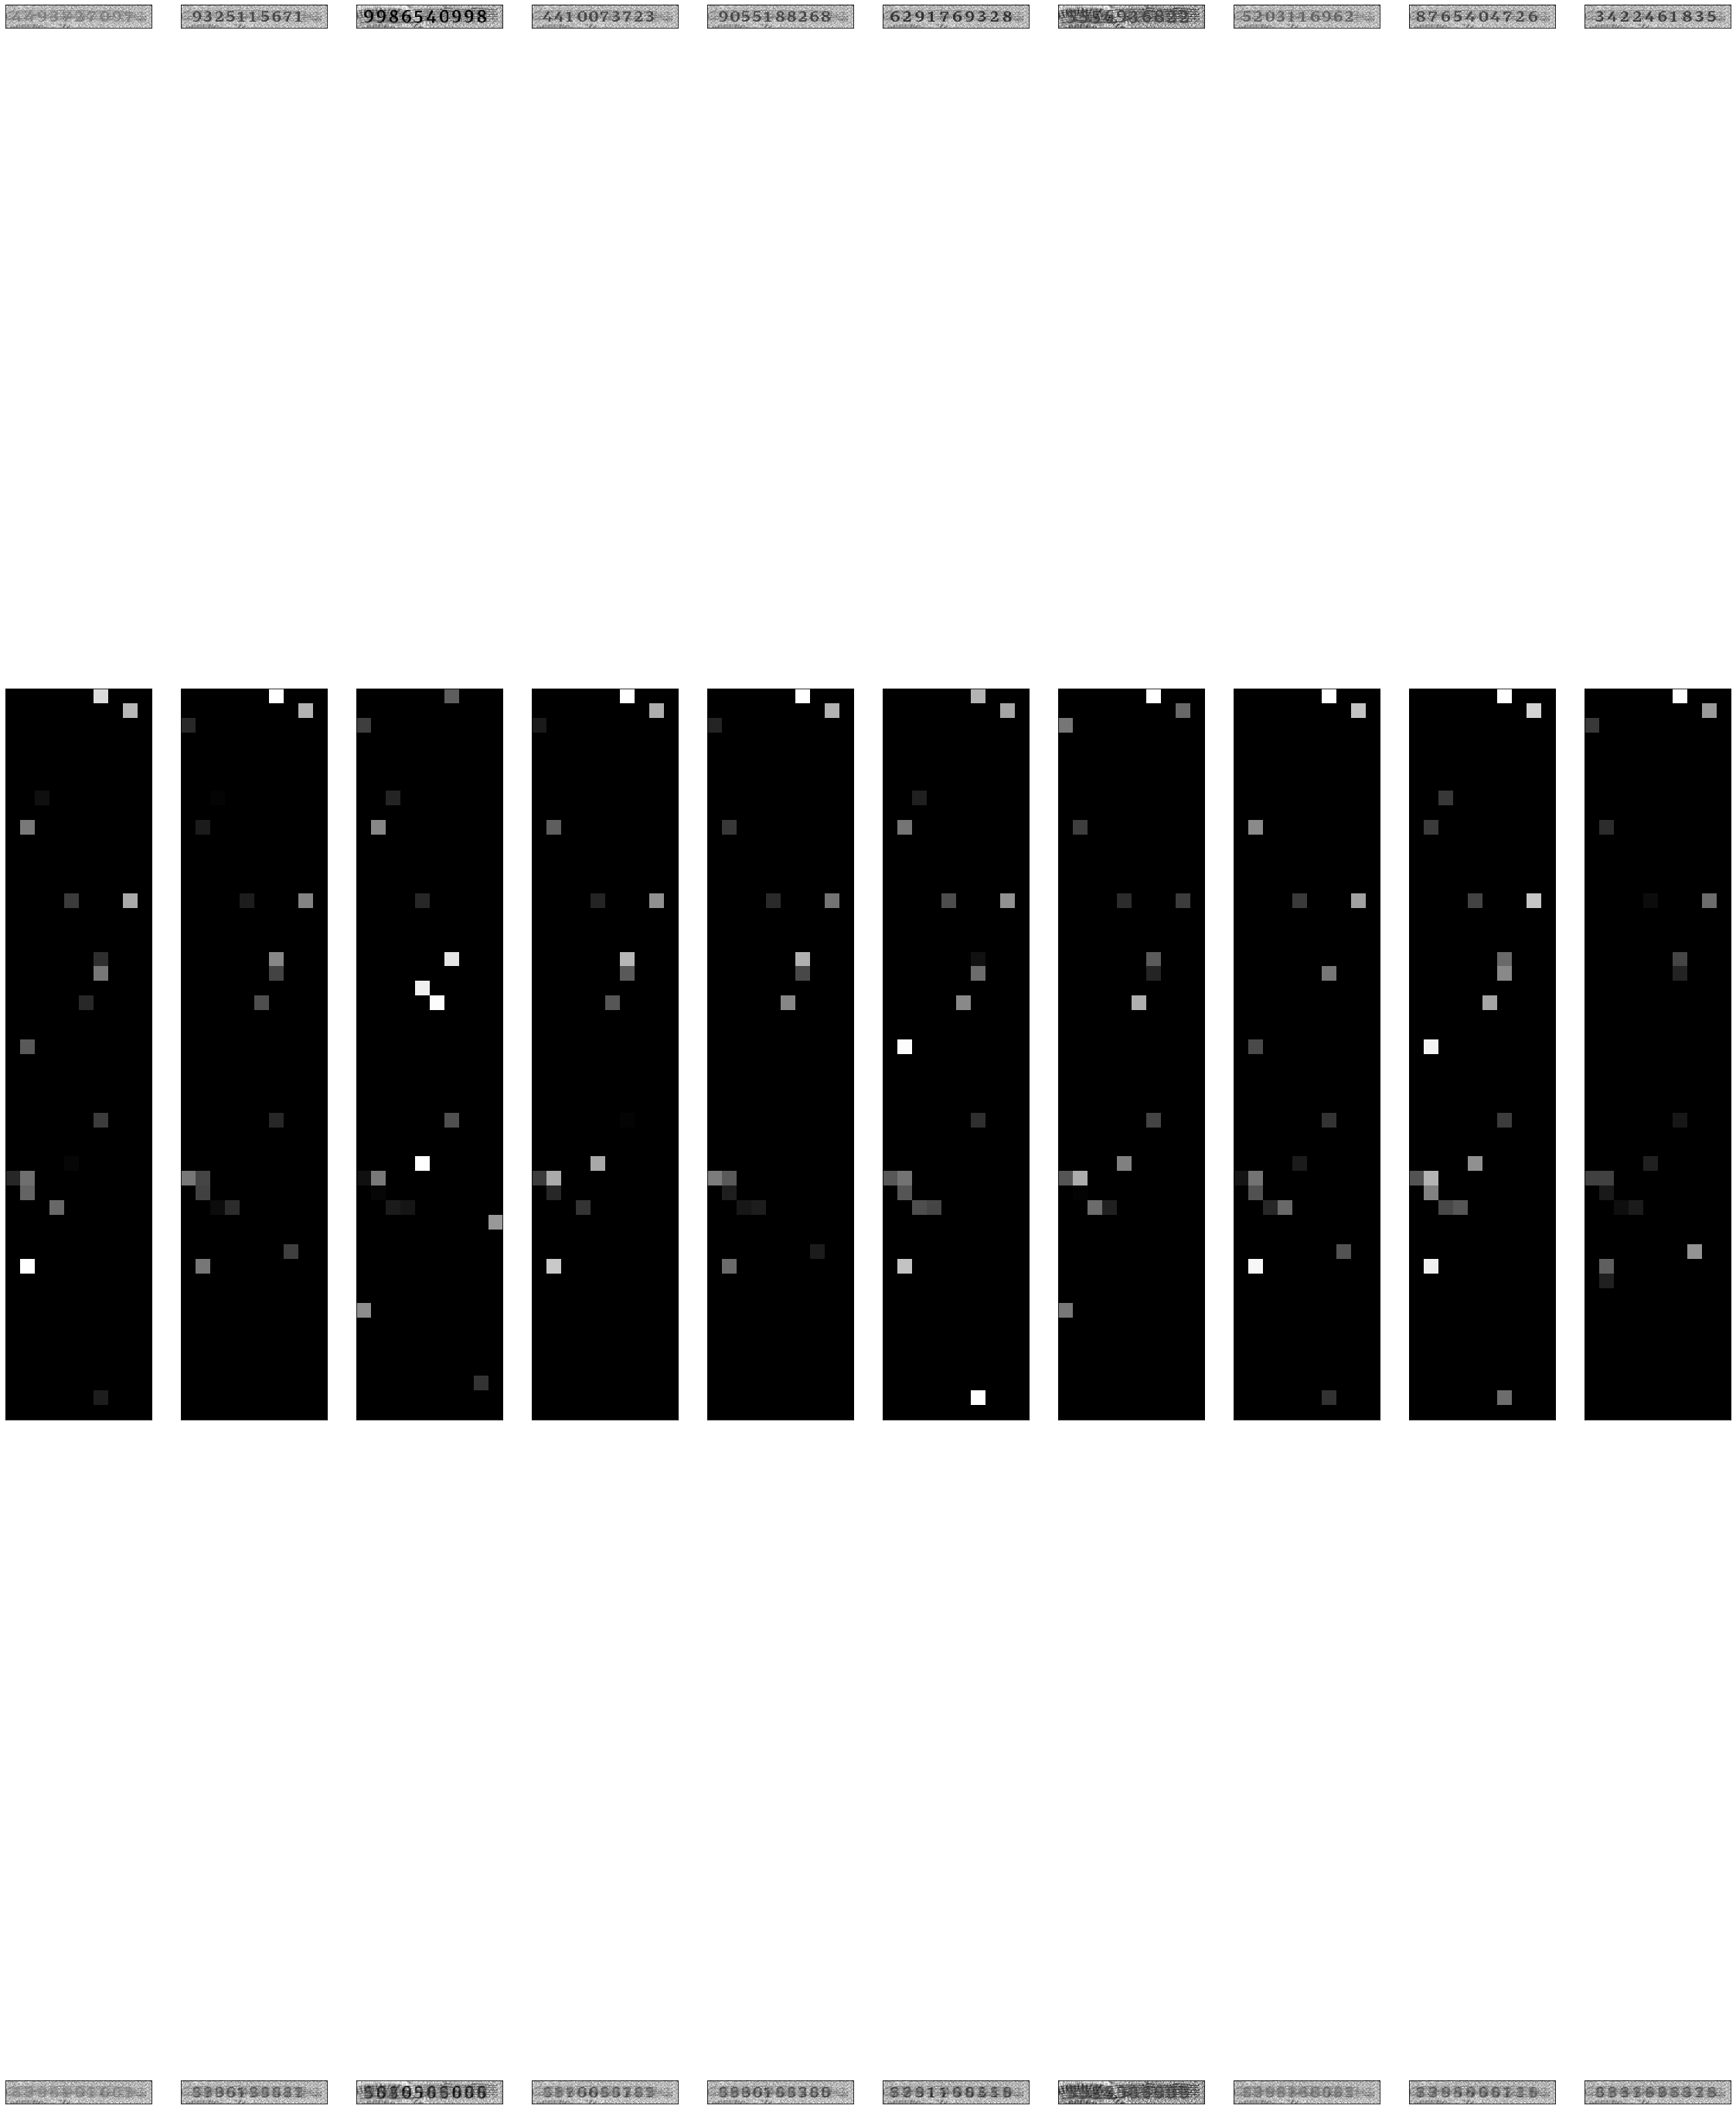

In [14]:
plt.figure(figsize=( 40,70))

for i, image_idx in enumerate(random_test_images):
    
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(40, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(50, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    
    ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(40, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()